# Postprocessing and Curation with SpikeInterface

## 1 Preparation

Import the modules required for this notebook

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface.full as si
import probeinterface as pi
from probeinterface.plotting import plot_probe

%matplotlib inline

Download the data for this notebook (this may take a while)

In [2]:
import os
import zipfile
import requests

fnames = ["openephys_preprocessed", "results_KS4", "results_SPC", "results_TDC"]
urls = [
    "https://uni-bonn.sciebo.de/s/2LbWWs3VPVrQkLO",
    "https://uni-bonn.sciebo.de/s/26X6qhAAYq1uJfZ",
    "https://uni-bonn.sciebo.de/s/FnRPj7EQSYXFIEg",
    "https://uni-bonn.sciebo.de/s/EkdnDNhvF68HC9D",
]

for url, fname in zip(urls, fnames):
    print("downloading", fname)
    response = requests.get(f"{url}/download")
    with open(f"{fname}.zip", "wb") as file:
        file.write(response.content)

    with zipfile.ZipFile(f"{fname}.zip", "r") as zip_ref:
        zip_ref.extractall(".")
        extracted_name = zip_ref.namelist()[0].split("/")[0]
        if extracted_name != fname:
            os.rename(extracted_name, fname)
    os.remove(f"{fname}.zip")
print("Done!")

## 2 Extracting Waveforms and Computing Templates

After spike sorting, we have the times when spikes occurred, but to
validate and understand the sorted units, we need to examine their
shapes. This process involves extracting the raw voltage “snippets”
(waveforms) around each detected spike time. SpikeInterface streamlines
this with the SortingAnalyzer object, a central hub that links a sorting
result with its corresponding recording. In this section, you will learn
how to create an analyzer and compute “extensions” like spike waveforms
and average templates, which are the basis for all subsequent quality
control and analysis.

| Code | Description |
|------------------------------------|------------------------------------|
| `rec = si.load_extractor("mydir")` | Load a recording extractor stored in the folder `"mydir"`. |
| `sorting = si.read_sorter_folder("results_SPC")` | Load spike sorting results from a folder. |
| `analyzer = si.create_sorting_analyzer(sorting, rec)` | Create an analyzer by pairing sorting results with the recording. |
| `analyzer.compute("random_spikes", **kwargs)` | Randomly sample spikes from each unit for efficient processing. |
| `analyzer.compute("waveforms", **kwargs)` | Extract spike waveforms for the sampled spikes. |
| `analyzer.compute("templates", **kwargs)` | Compute average templates from the extracted waveforms. |
| `ext = analyzer.get_extension("extension_name")` | Get a computed extension (e.g., “waveforms”) from the analyzer. |
| `ext.get_data()` | Get the raw data from an extension object. |
| `ext.get_waveforms_one_unit(unit_id)` | Get the waveforms for a single specified unit. |
| `ext.get_unit_template(unit_id, operator)` | Get the template for a single unit (e.g., using “average” or “median”). |
| `plt.plot(template)` | Plot the average template waveform. |

------------------------------------------------------------------------

Load the recoring extractor stored in the directory
`"openephys_preprocessed"` and the sorting results stored in the
directory `"results_SPC"` and create a sorting `analyzer`.

In [3]:
rec = si.load("openephys_preprocessed")
sort = si.read_sorter_folder("results_SPC")
analyzer = si.create_sorting_analyzer(sort, rec)

<span class="theorem-title">**Example 1**</span> Randomly sample up to
`300` spikes from every unit.

In [4]:
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=300)

<span class="theorem-title">**Example 2**</span> Get the
`"random_spikes"` extension from the `analyzer` and print the total
number of spikes sampled.

In [5]:
ext = analyzer.get_extension("random_spikes")
spike_indices = ext.get_data()
print("N_spikes = ", len(spike_indices))

N_spikes =  34096

<span class="theorem-title">**Exercise 1**</span> Randomly sample up to
`500` spikes per unit and print the total number of spikes sampled.

*Solution.*

In [6]:
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
ext = analyzer.get_extension("random_spikes")
spike_indices = ext.get_data()
print("N_spikes = ", len(spike_indices))

N_spikes =  52646

<span class="theorem-title">**Exercise 2**</span> Randomly sample spikes
and use `method="all"` to get of the spikes (omit the
`max_spikes_per_unit` argument). Then, print the total number of spikes
sampled.

*Solution.*

In [8]:
analyzer.compute("random_spikes", method="all")
ext = analyzer.get_extension("random_spikes")
spike_indices = ext.get_data()
print("N_spikes = ", len(spike_indices))

N_spikes =  145296

<span class="theorem-title">**Example 3**</span> Compute the
`"waveforms"` for all of the spikes using the `ms_before = 2` and
`ms_after=3` milliseconds after each spike.

In [10]:
analyzer.compute("waveforms", ms_before=2, ms_after=3)

<span class="theorem-title">**Example 4**</span> Get the `"waveforms"`
extension from the `analyzer`, then get the array of waveforms for unit
`3` and its `.shape` (dimensions represent spikes, samples and
channels).

In [11]:
ext = analyzer.get_extension("waveforms")
wfs = ext.get_waveforms_one_unit(unit_id=3)
wfs.shape

(3331, 150, 13)

<span class="theorem-title">**Exercise 3**</span> Compute the
`"waveforms"` for all of the spikes using the `ms_before = 1` and
`ms_after=2` milliseconds after each spike. Then, get the waveforms for
unit `3` and print their `.shape`.

*Solution.*

In [12]:
analyzer.compute("waveforms", ms_before=1, ms_after=2)
ext = analyzer.get_extension("waveforms")
wfs = ext.get_waveforms_one_unit(unit_id=3)
wfs.shape

(3331, 90, 13)

<span class="theorem-title">**Example 5**</span> Compute the
`"templates"` for the extracted `"waveforms"` using the `"average"`
operator.

In [14]:
analyzer.compute("templates", operators=["average"])

<span class="theorem-title">**Example 6**</span> Get the `"average"`
template for unit `3` and print its shape.

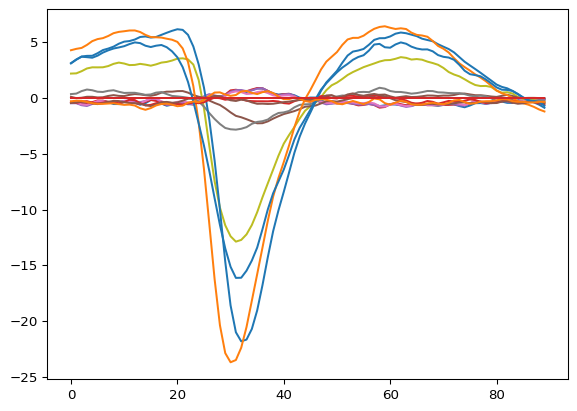

In [15]:
ext = analyzer.get_extension("templates")
template = ext.get_unit_template(unit_id=3, operator="average")
plt.plot(template);

<span class="theorem-title">**Exercise 4**</span> Compute the
`"templates"` for the extracted `"waveforms"` using the `"median"`
operator.

*Solution.*

In [16]:
analyzer.compute("templates", operators=["median"])

<span class="theorem-title">**Exercise 5**</span> Get the `"median"`
template for unit `3` and print its shape.

*Solution.*

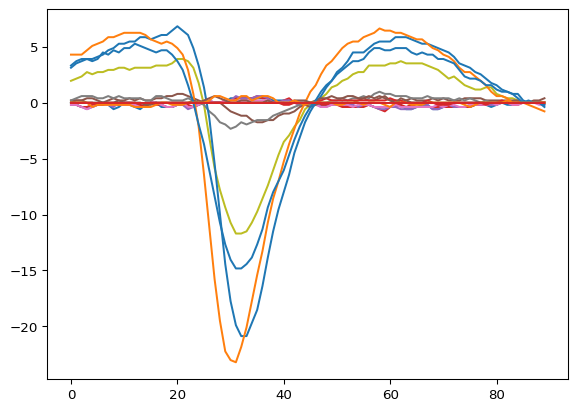

In [18]:
ext = analyzer.get_extension("templates")
template = ext.get_unit_template(unit_id=3, operator="median")
plt.plot(template);

## 3 Curating Units with Quality Metrics

Spike sorting algorithms are not perfect; they often produce units that
represent noise, artifacts, or a mix of multiple neurons (multi-unit
activity). Therefore, a critical step in the workflow is to compute
quality metrics to automatically curate the results and identify
high-quality, well-isolated single units. SpikeInterface provides many
metrics, including signal-to-noise ratio (SNR) and Inter-Spike Interval
(ISI) violations. In this section, you will learn how to compute these
metrics and use them to filter the sorting output, keeping only the
units that meet your quality criteria.

| Code | Description |
|------------------------------------|------------------------------------|
| `analyzer.compute("noise_levels")` | Compute the noise level on each channel, a prerequisite for SNR. |
| `analyzer.compute("quality_metrics", metric_names=[...])` | Compute specified quality metrics for all units. |
| `ext = analyzer.get_extension("quality_metrics")` | Get the computed quality metrics from the analyzer. |
| `df = ext.get_data()` | Get the quality metrics as a pandas DataFrame. |
| `plt.hist(df["metric_name"])` | Plot a histogram of a specific quality metric’s distribution. |
| `unit_ids = analyzer.unit_ids[df["metric_name"] > value]` | Select unit IDs that satisfy a condition based on a quality metric. |
| `curated_units = sort.select_units(unit_ids=unit_ids)` | Create a new, curated sorting object containing only the selected units. |
| `curated_units.save(folder="...", overwrite=True)` | Save the curated sorting results to a new folder. |

------------------------------------------------------------------------

<span class="theorem-title">**Example 7**</span> Compute the
`"noise_levels"` and `"quality_metrics"` extension with the metrics
`"snr"` and `"num_spikes"`. Then, get the extension data and print the
data frame.

In [20]:
analyzer.compute("noise_levels")
analyzer.compute("quality_metrics", metric_names=["snr", "num_spikes"])
ext = analyzer.get_extension("quality_metrics")
df = ext.get_data()
df

127 rows × 2 columns

<span class="theorem-title">**Exercise 6**</span> Plot the distribution
of `"snr"` in a histogram.

*Solution.*

(array([44., 37., 21., 10.,  8.,  4.,  2.,  0.,  0.,  1.]),
 array([ 1.99451674,  6.63912782, 11.2837389 , 15.92834998, 20.57296107,
        25.21757215, 29.86218323, 34.50679432, 39.1514054 , 43.79601648,
        48.44062757]),
 <BarContainer object of 10 artists>)

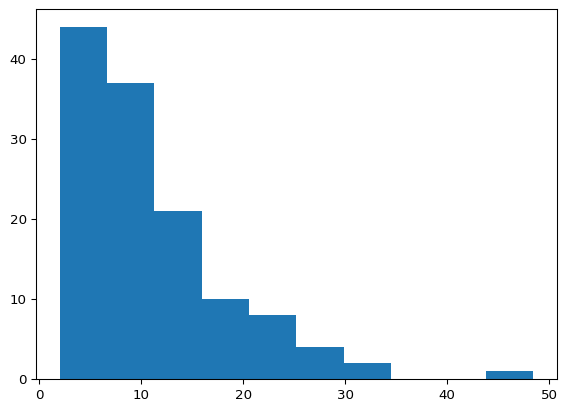

In [21]:
plt.hist(df["snr"])

<span class="theorem-title">**Exercise 7**</span> Compute the
`"quality_metrics"` extension with the `"isi_violation"` metric, get the
extension data and print the data frame.

*Solution.*

In [23]:
analyzer.compute("quality_metrics", metric_names=["isi_violation"])
ext = analyzer.get_extension("quality_metrics")
df = ext.get_data()
df

127 rows × 4 columns

<span class="theorem-title">**Exercise 8**</span> Plot the distribution
of `"isi_violation_count"` in a histogram.

*Solution.*

(array([93., 11.,  8.,  5.,  4.,  2.,  2.,  0.,  1.,  1.]),
 array([  0. ,  30.9,  61.8,  92.7, 123.6, 154.5, 185.4, 216.3, 247.2,
        278.1, 309. ]),
 <BarContainer object of 10 artists>)

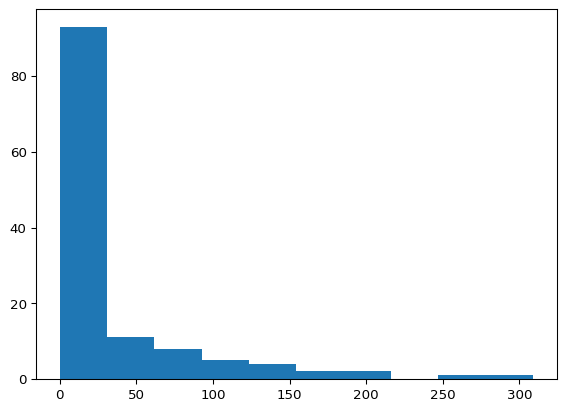

In [25]:
plt.hist(df["isi_violations_count"])

<span class="theorem-title">**Example 8**</span> Get the units with a
SNR above 10.

In [27]:
unit_ids = analyzer.unit_ids[df["snr"]>10]
unit_ids

array([ 11,  15,  17,  18,  19,  22,  23,  26,  27,  28,  30,  31,  33,
        34,  37,  38,  39,  40,  41,  43,  44,  45,  47,  50,  52,  53,
        55,  57,  59,  60,  61,  63,  65,  68,  72,  75,  76,  78,  81,
        82,  84,  87,  90,  92,  95,  97,  99, 104, 111, 112, 114, 115,
       116, 117])

<span class="theorem-title">**Exercise 9**</span> Get the units with an
`"isi_violations_ratio"` below 4.

*Solution.*

In [28]:
unit_ids = analyzer.unit_ids[(df["isi_violations_ratio"]<4)]
unit_ids

array([  2,   3,   4,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        63,  64,  65,  66,  68,  70,  71,  73,  74,  75,  76,  77,  79,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 105, 106, 107, 109, 110,
       111, 112, 113, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126])

<span class="theorem-title">**Exercise 10**</span> Use
`sort.select_units` to select the filtered `unit_ids` and return the
`curated_units`. Then use `curated_units.save()` to save them.

*Solution.*

In [30]:
curated_units = sort.select_units(unit_ids=unit_ids)
curated_units.save(folder="sorting_curated", overwrite=True)
si.load("sorting_curated")

/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/spikeinterface/core/basesorting.py:261: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")

NumpyFolder (NumpyFolderSorting): 105 units - 1 segments - 30.0kHz Unit IDs [ 2 3 4 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 31 32 33 34 35 36 37 38 39 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 63 64
 65 66 68 70 71 73 74 75 76 77 79 82 83 84 85 86 87 88
 89 90 92 93 94 95 96 97 98 99 100 101 102 103 105 106 107 109
 110 111 112 113 115 117 118 119 120 121 122 123 124 125 126] Annotations __sorting_info__ : {'recording': {'class': 'spikeinterface.extractors.neoextractors.openephys.OpenEphysBinaryRecordingExtractor', 'module': 'spikeinterface', 'version': '0.102.2', 'kwargs': {'all_annotations': False, 'stream_id': '0', 'folder_path': '/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/11_spike_sorting_with_spikeinterface/openephys_raw/2023-08-23_15-56-05', 'load_sync_channel': False, 'load_sync_timestamps': False, 'experiment_names': None}, 'annotations': {'is_filtered': False, 'experiment_name': 'experiment1', 'probe_0_planar_contour': [[-10.0, 900.0], [-10.0, -10.0], [12.0, -30.0], [30.0, 10.0], [70.0, 900.0]]}, 'properties': {'group': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'location': [[0.0, 775.0], [0.0, 400.0], [0.0, 450.0], [0.0, 700.0], [0.0, 650.0], [0.0, 575.0], [22.5, 762.5], [22.5, 537.5], [0.0, 750.0], [0.0, 375.0], [0.0, 525.0], [22.5, 437.5], [22.5, 487.5], [22.5, 562.5], [0.0, 550.0], [22.5, 687.5], [0.0, 475.0], [22.5, 787.5], [22.5, 512.5], [0.0, 625.0], [0.0, 725.0], [22.5, 737.5], [0.0, 425.0], [22.5, 662.5], [0.0, 500.0], [0.0, 675.0], [0.0, 600.0], [22.5, 612.5], [22.5, 462.5], [22.5, 587.5], [22.5, 712.5], [22.5, 637.5], [0.0, 275.0], [22.5, 337.5], [22.5, 212.5], [0.0, 100.0], [0.0, 350.0], [22.5, 137.5], [0.0, 50.0], [22.5, 12.5], [22.5, 312.5], [22.5, 162.5], [22.5, 112.5], [22.5, 237.5], [0.0, 175.0], [22.5, 387.5], [0.0, 75.0], [22.5, 262.5], [0.0, 300.0], [0.0, 200.0], [0.0, 325.0], [22.5, 37.5], [0.0, 225.0], [22.5, 412.5], [0.0, 150.0], [22.5, 62.5], [22.5, 287.5], [0.0, 250.0], [22.5, 362.5], [22.5, 87.5], [0.0, 125.0], [0.0, 25.0], [0.0, 0.0], [22.5, 187.5]], 'gain_to_uV': [0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426], 'offset_to_uV': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, 'relative_paths': False}, 'params': {'sorter_name': 'spykingcircus2', 'sorter_params': {'general': {'ms_before': 2, 'ms_after': 2, 'rad

## 4 Compare Different Sorters

Different spike sorters use different algorithms and may produce
different results on the same dataset. By comparing the outputs of
multiple sorters, we can identify a “consensus” set of units found by
all (or most) of them, which increases our confidence in their validity.
This comparison also highlights where sorters disagree, pointing to
units that may be difficult to sort or require manual inspection.
SpikeInterface provides convenient tools to compare sorters and
visualize their agreement. In this section, you will learn how to
compare sorters and interpret the resulting agreement matrices and
summary plots.

| Code | Description |
|------------------------------------|------------------------------------|
| `comp = si.compare_two_sorters(...)` | Compare two sorters, returning a comparison object. |
| `si.plot_agreement_matrix(comp, **kwargs)` | Plot the agreement matrix for a pairwise sorter comparison. |
| `multi_comp = si.compare_multiple_sorters(...)` | Compare a list of multiple sorters, returning a multi-comparison object. |
| `si.plot_multicomparison_agreement(multi_comp)` | Plot a pie chart summarizing the agreement between multiple sorters. |
| `si.plot_multicomparison_agreement_by_sorter(multi_comp)` | Plot agreement summaries broken down by each individual sorter. |

Load the sorting results from Spykingcircus, Kilosort4 and Tridesclous.

In [32]:
sorting_SPC = si.read_sorter_folder("results_SPC")
sorting_KS4 = si.read_sorter_folder("results_KS4")
sorting_TDC = si.read_sorter_folder("results_TDC")

<span class="theorem-title">**Example 9**</span> Compare the results
from the Spikingcircus and Kilosort4 sorters using the `"count"`
agreement methods and plot the agreement matrix. A clearly visible
diagonal indicates that the sorters agree on a given unit.

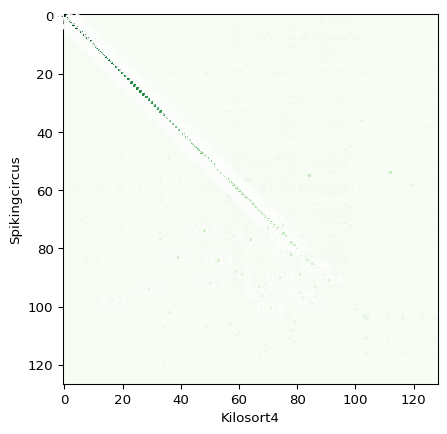

In [33]:
comp = si.compare_two_sorters(
    sorting_SPC, sorting_KS4, "Spikingcircus", "Kilosort4", agreement_method="count"
)
si.plot_agreement_matrix(comp, unit_ticks=False)

<span class="theorem-title">**Exercise 11**</span> Compare the results
from the Spikingcircus and Kilosort4 sorters using the `"distance"`
agreement methods and plot the agreement matrix.

*Solution.*

/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
  agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)

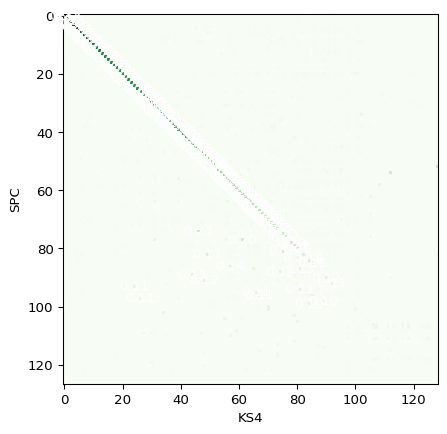

In [34]:
comp = si.compare_two_sorters(
    sorting_SPC, sorting_KS4, "SPC", "KS4", agreement_method="distance"
)
si.plot_agreement_matrix(comp, unit_ticks=False)

<span class="theorem-title">**Exercise 12**</span> Load the results from
the Tridesclous sorter and compare them to the results from
Spikingcircus by plotting the agreement matrix.

*Solution.*

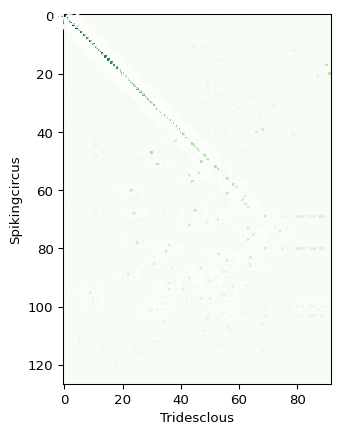

In [36]:
sorting_TDC = si.read_sorter_folder("results_TDC")
comp = si.compare_two_sorters(
    sorting_SPC, sorting_TDC, "Spikingcircus", "Tridesclous", agreement_method="count"
)
si.plot_agreement_matrix(comp, unit_ticks=False)

<span class="theorem-title">**Example 10**</span> Compare the results
from all three sorters using the `"count"` agreement method.

In [38]:
multi_comp = si.compare_multiple_sorters(
    [sorting_SPC, sorting_KS4, sorting_TDC],
    ["Spikingcircus", "Kilosort4", "Tridesclous"],
    agreement_method="count",
)

<span class="theorem-title">**Exercise 13**</span> Use
`si.plot_multicomparison_agreement` to plot the `multi_comp`.

*Solution.*

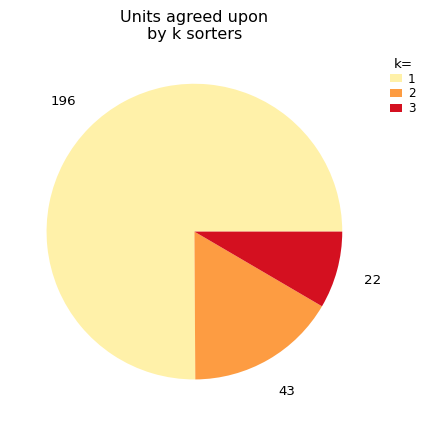

In [39]:
si.plot_multicomparison_agreement(multi_comp)

<span class="theorem-title">**Exercise 14**</span> Compare the results
from all three sorters using the `"distance"` agreement method.

*Solution.*

In [41]:
multi_comp = si.compare_multiple_sorters(
    [sorting_SPC, sorting_KS4, sorting_TDC],
    ["Spikingcircus", "Kilosort4", "Tridesclous"],
    agreement_method="distance",
)

/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
  agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)
/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
  agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)
/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
  agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)

<span class="theorem-title">**Exercise 15**</span> Plot the
mutlicomparison agreement.

*Solution.*

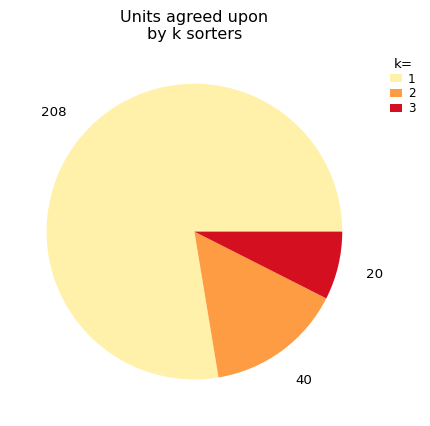

In [43]:
si.plot_multicomparison_agreement(multi_comp)

<span class="theorem-title">**Exercise 16**</span> Plot the
mutlicomparison agreement separately for each sorter.

*Solution.*

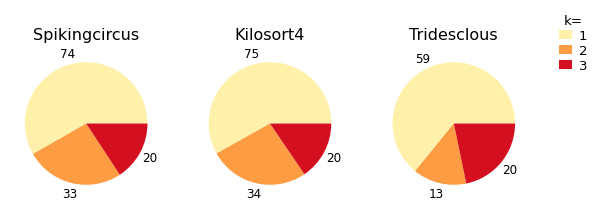

In [45]:
si.plot_multicomparison_agreement_by_sorter(multi_comp)

## 5 Localizing Detected Units

Knowing where a unit is physically located on the probe is crucial for
validating sorting results (e.g., a single neuron should be localized in
space) and for any spatial analysis of neural activity. SpikeInterface
can estimate the position of each unit by analyzing the amplitude of its
average waveform across the different electrode channels. In this
section we will explore computing unit locations using various methods,
such as “center of mass” and “monopolar triangulation,” and visualizing
these locations in 2D and 3D space relative to the probe geometry.

| Code | Description |
|------------------------------------|------------------------------------|
| `si.plot_unit_waveforms(analyzer, **kwargs)` | Create an interactive plot showing unit waveforms on the probe. |
| `unit_locations = si.compute_unit_locations(analyzer, method)` | Compute unit locations using a specified method (e.g., “center_of_mass”). |
| `probe = rec.get_probe()` | Retrieve the probe information from a recording object. |
| `plot_probe(probe)` | Plot the geometry of the probe. |
| `plt.scatter(x, y)` | Create a 2D scatter plot of x and y coordinates. |
| `ax = plt.subplot(projection='3d')` | Create a 3-dimensional plot axis. |
| `ax.scatter(x, y, z)` | Create a 3D scatter plot of x, y, and z coordinates. |
| `ax.set(xlim=..., ylim=...)` | Set the x and y axis limits for a plot. |

------------------------------------------------------------------------

Run the cell below to create an interactive widget that shows, for each
unit, the waveforms and the electrode locations where they were
recorded.

In [47]:
%matplotlib widget
si.plot_unit_waveforms(analyzer, backend="ipywidgets")
%matplotlib inline

<span class="theorem-title">**Example 11**</span> Compute the unit
locations using the `"center_of_mass"` method and print the shape of the
returned `unit_locations`.

In [48]:
unit_locations = si.compute_unit_locations(analyzer, method="center_of_mass")
unit_locations.shape

(127, 2)

<span class="theorem-title">**Example 12**</span> Get the probe from
`rec` and plot it together with the `x` and `y` `unit_locations`.

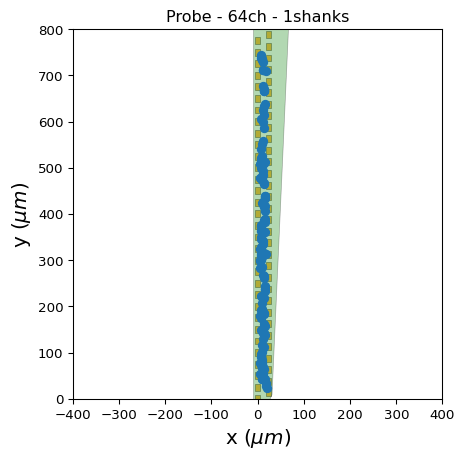

In [49]:
probe = rec.get_probe()
plot_probe(probe)
x = unit_locations[:, 0]
y = unit_locations[:, 1]
plt.scatter(x, y)
plt.xlim(-400, 400)
plt.ylim(0, 800)

<span class="theorem-title">**Exercise 17**</span> Compute the unit
locations using the `"monopolar_triangulation"` method and print the
shape of the returned `unit_locations`.

*Solution.*

In [50]:
unit_locations = si.compute_unit_locations(analyzer, method="monopolar_triangulation")
unit_locations.shape

(127, 3)

<span class="theorem-title">**Exercise 18**</span> Plot the `probe`
together with the `x` and `y` `unit_locations`.

*Solution.*

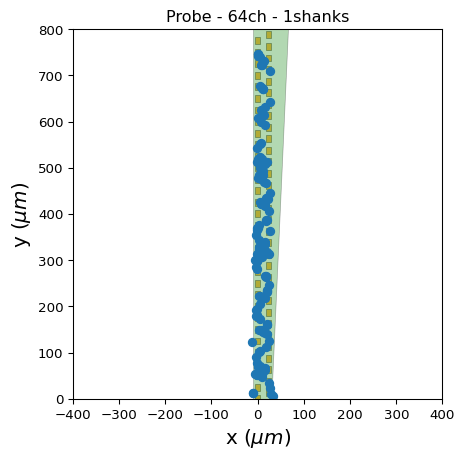

In [52]:
probe = rec.get_probe()
plot_probe(probe)
x = unit_locations[:, 0]
y = unit_locations[:, 1]
plt.scatter(x, y)
plt.xlim(-400, 400)
plt.ylim(0, 800)

<span class="theorem-title">**Example 13**</span> Create a 3D plot of
the `x`, `y` and `z` `unit_locations`.

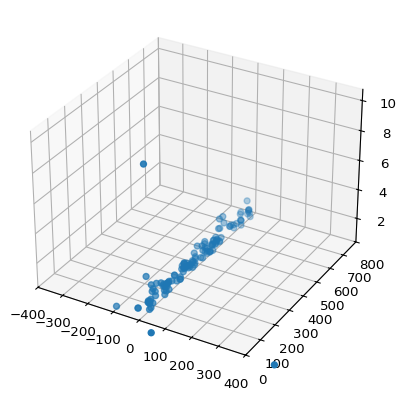

In [54]:
x = unit_locations[:, 0]
y = unit_locations[:, 1]
z = unit_locations[:, 2]
ax = plt.subplot(projection="3d")
ax.scatter(x, y, z)
ax.set(xlim=(-400, 400), ylim=(0, 800))

<span class="theorem-title">**Exercise 19**</span> Compute the unit
locations using the `"grid_convolution"` method and print the shape of
the returned `unit_locations`.

*Solution.*

In [55]:
unit_locations = si.compute_unit_locations(analyzer, method="grid_convolution")
unit_locations.shape

(127, 3)

<span class="theorem-title">**Exercise 20**</span> Create a 3D plot of
the `x`, `y` and `z` `unit_locations`.

*Solution.*

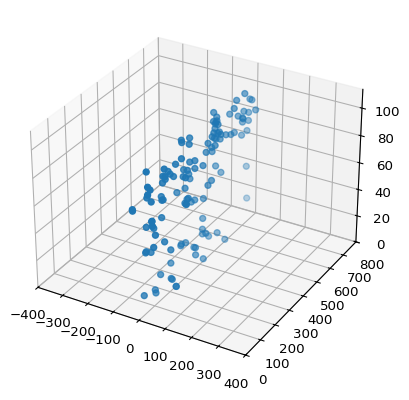

In [57]:
x = unit_locations[:, 0]
y = unit_locations[:, 1]
z = unit_locations[:, 2]
ax = plt.subplot(projection="3d")
ax.scatter(x, y, z)
ax.set(xlim=(-400, 400), ylim=(0, 800))